In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# get model
model_height = 224
model_width = 224
model = tf.keras.applications.VGG16(include_top=True, 
                                    weights='imagenet', 
                                    input_shape=(model_height, model_width, 3))
#model.summary()

553467904/553467096 [==============================] - 4s 0us/step


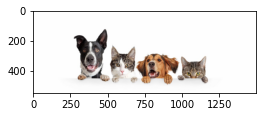

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

height = 550
width  = 1500

PATH  = '/content/gdrive/My Drive/data/template-matching/'
image = kimage.load_img(PATH+'image7.jpg', target_size=(height, width))

plt.figure(figsize=(4,4))
plt.imshow(image)

(550, 1500)


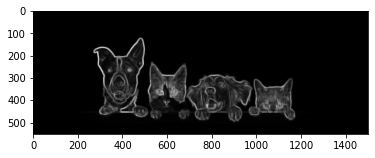

In [ ]:
import numpy as np
import cv2
import math
from scipy.ndimage.filters import generic_filter

img  = cv2.imread(PATH+'image7.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (1500, 550))
gray = gray.astype('float')
gray_std = generic_filter(gray, np.std, size=7)
#gray_std = gray_std*2.6

plt.figure(figsize=(6,6))
plt.imshow(gray_std, cmap='gray')
print(gray_std.shape)

In [ ]:
# compute features
image_np = kimage.img_to_array(image)
image_np = np.expand_dims(image_np, axis=0)
print(image_np.shape)

(1, 550, 1500, 3)


count= 19272


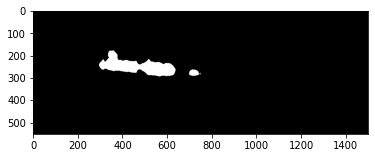

In [ ]:
# debug, check
count = 0
map = np.zeros_like(gray_std)
for i in range(height-model_height+1):
  for j in range(width-model_width+1):
    flag = gray_std[i:i+model_height, j:j+model_width]
    flag = np.sum(flag) / (model_height*model_width*1.0)
    if (flag > 45.0):
      count = count + 1
      map[i,j] = 1.0

print('count=', count)
plt.figure(figsize=(6,6))
plt.imshow(map, cmap='gray')

In [ ]:
# compute predictions - 30mins
prediction_data = []
for i in range(height-model_height+1):
  for j in range(width-model_width+1):
    flag = gray_std[i:i+model_height, j:j+model_width]
    flag = np.sum(flag) / (model_height*model_width*1.0)
    if (flag > 45.0):
      patch = image_np[:, i:i+model_height, j:j+model_width, :]
      patch = preprocess_input(patch)
      patch = model.predict(patch)
      prediction_data.append( (tf.math.reduce_max(patch[0]).numpy(), 
                              i, j, tf.math.argmax(patch[0]).numpy()) )

In [ ]:
def getKey(item):
    return item[0]

tp_sorted = sorted(prediction_data, key=getKey, reverse=True)
print(tp_sorted[:3])

[(1.0, 179, 362, 644), (1.0, 179, 363, 644), (1.0, 180, 341, 644)]


In [ ]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)
print(type(labels))
print(labels[227])

<class 'dict'>
kelpie


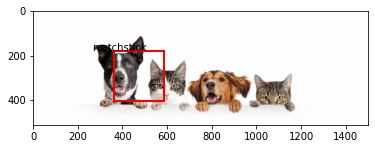

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(PATH+'image7.jpg', target_size=(510, 1500))

fig, ax = plt.subplots()
ax.imshow(im)

# Create a Rectangle patch
for i in range(1): 
  rect = patches.Rectangle((tp_sorted[i][2], tp_sorted[i][1]), 224, 224, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.text(tp_sorted[i][2]-100, tp_sorted[i][1], labels[tp_sorted[i][3]])

plt.show()